In [5]:
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PlotFuncs import *
from LabFuncs import *
from Params import *
from HaloFuncs import *
from WIMPFuncs import *
from scipy.stats import norm
import pandas

# Halo params
HaloModel = SHMpp
v0 = HaloModel.RotationSpeed
v_esc = HaloModel.EscapeSpeed
sig_beta = HaloModel.SausageDispersionTensor
sig_iso = array([1.0,1.0,1.0])*v0/sqrt(2.0)
day = 67.0 

# Load shards
df = pandas.read_csv('../data/FitShards_red.csv')
names = df.group_id
nshards = size(names)
velocities = zeros(shape=(nshards,3))
dispersions = zeros(shape=(nshards,3))
velocities[0:(nshards),0] = df.vx # stream velocities
velocities[0:(nshards),1] = df.vy
velocities[0:(nshards),2] = df.vz
dispersions[0:(nshards),0] = df.sigx # dispersion tensors
dispersions[0:(nshards),1] = df.sigy
dispersions[0:(nshards),2] = df.sigz
pops = df.population
Psun = df.Psun
weights = ShardsWeights(names,pops,Psun)


nv = 300
v_min = linspace(0.0001,800.0,nv)

gmin_Iso = 1.0*gvmin_Triaxial(v_min,day,sig_iso,GravFocus=False)
gmin_Saus = 1.0*gvmin_Triaxial(v_min,day,sig_beta,GravFocus=False)

gmin_Iso_gf = 1.0*gvmin_Triaxial(v_min,day,sig_iso,GravFocus=True)
gmin_Saus_gf = 1.0*gvmin_Triaxial(v_min,day,sig_beta,GravFocus=True)

gmin_sub = zeros(shape=(nshards,nv))
gmin_sub_gf = zeros(shape=(nshards,nv))
for i in range(0,nshards):
    v_s = velocities[i,:]
    sig_s = dispersions[i,:]
    gmin_sub[i,:] = weights[i]*gvmin_Triaxial(v_min,day,sig_s,v_shift=v_s,GravFocus=False)
    gmin_sub_gf[i,:] = weights[i]*gvmin_Triaxial(v_min,day,sig_s,v_shift=v_s,GravFocus=True)        

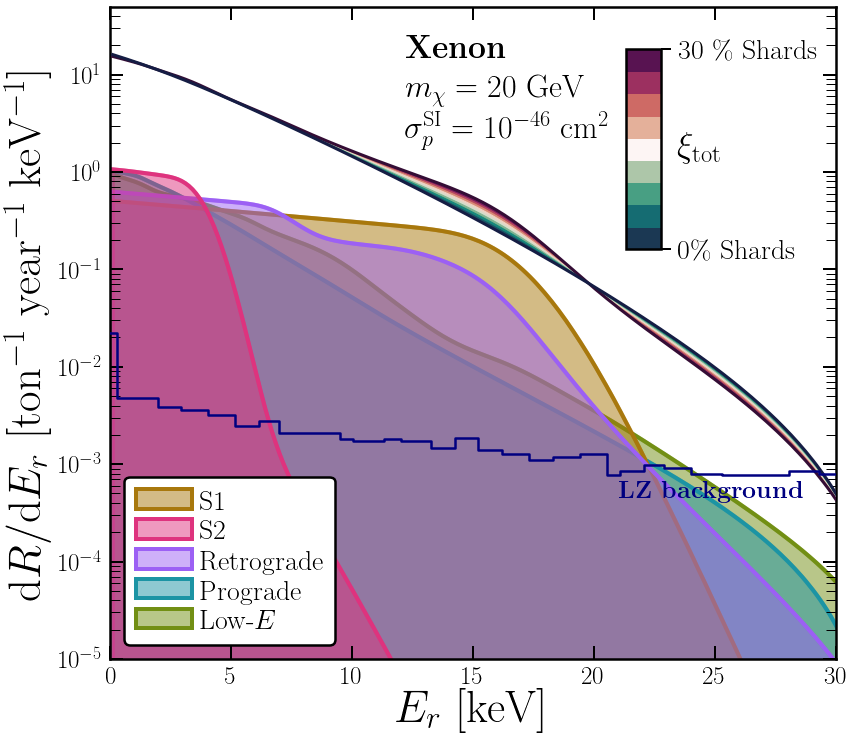

In [6]:
import cmocean

def InterpdR(Evals,A,m_chi,sigma_p,rho_0=0.55):
    v_minE = MinimumWIMPSpeed(Evals,A,m_chi)
    dR_Iso = diffRecoilRate_SI(Evals,interp(v_minE,v_min,gmin_Iso),A,sigma_p,m_chi,rho_0=rho_0)
    dR_Iso_gf = diffRecoilRate_SI(Evals,interp(v_minE,v_min,gmin_Iso_gf),A,sigma_p,m_chi,rho_0=rho_0)
    dR_Saus = diffRecoilRate_SI(Evals,interp(v_minE,v_min,gmin_Saus),A,sigma_p,m_chi,rho_0=rho_0)
    dR_Saus_gf = diffRecoilRate_SI(Evals,interp(v_minE,v_min,gmin_Saus_gf),A,sigma_p,m_chi,rho_0=rho_0)
    
    dR_Sh = zeros(shape=(nshards,ne))
    dR_Sh_gf = zeros(shape=(nshards,ne))
    for i in range(0,nshards):
        dR_Sh[i,:] = diffRecoilRate_SI(Evals,interp(v_minE,v_min,gmin_sub[i,:]),A,sigma_p,m_chi,rho_0=rho_0)
        dR_Sh_gf[i,:] = diffRecoilRate_SI(Evals,interp(v_minE,v_min,gmin_sub_gf[i,:]),A,sigma_p,m_chi,rho_0=rho_0) 
    return dR_Iso,dR_Iso_gf,dR_Saus,dR_Saus_gf,dR_Sh,dR_Sh_gf



# Figure setup
xlab = r"$E_r$ [keV]"
ylab = r'$\textrm{d}R/\textrm{d}E_r$ [ton$^{-1}$ year$^{-1}$ keV$^{-1}$]'
fig,ax = MySquarePlot(xlab,ylab)

eta = 0.2
n_xi = 10
xi_max = 0.3
xi_vals = linspace(0.0,xi_max,n_xi)
col = (cmocean.cm.curl(linspace(0,1,n_xi)))
cmap = cmocean.cm.curl
labs = ['S1','S2','Retrograde','Prograde','Low-$E$']
nex = size(labs)
col_ex = (cmocean.cm.phase(linspace(0,0.9,nex)))



A = 131
m_chi = 20.0
sigma_p = 1.0e-46
ne = 1000
Evals = linspace(0.1,150.0,ne)

dR_Iso,dR_Iso_gf,dR_Saus,dR_Saus_gf,dR_Sh,dR_Sh_gf = InterpdR(Evals,A,m_chi,sigma_p)
dR0 = (1-eta)*dR_Iso_gf + eta*dR_Saus_gf
dR1 = sum(dR_Sh_gf,0)
for j in range(0,n_xi):
    i = n_xi-1-j
    xi = xi_vals[i]
    y = (1-xi-eta)*dR_Iso_gf + eta*dR_Saus_gf + xi*dR1
    ax.fill_between(Evals,y,y2=dR0,color=col[i,:],zorder=3)
    
ax.plot(Evals,(1-xi_max-eta)*dR_Iso_gf + eta*dR_Saus_gf + xi_max*dR1,'-',color=col[-1,:],linewidth=3,zorder=3)
ax.plot(Evals,dR0,'-',color=col[0,:],linewidth=3,zorder=3)

j = 0
zo = [-2,0,-1,-3,-4]
for idi in ['S1','S2','R','Ca','N']: 
    mask1 = zeros(shape=nshards)==1
    for i in range(0,nshards):
        mask1[i] = names[i].startswith(idi)
    dR_ex = xi_max*sum(dR_Sh[mask1,:],0)
    ax.fill_between(Evals,dR_ex,color=col_ex[j,:],lw=4,alpha=0.5,zorder=zo[j]) 
    ax.plot(Evals,dR_ex,color=col_ex[j,:],lw=4,alpha=1.0,zorder=zo[j]) 
    ax.fill_between([-1,-1],[-1,-3],facecolor=col_alpha(col_ex[j,:],0.5),edgecolor=col_ex[j,:],lw=4,label=labs[j],zorder=zo[j])
    j += 1

    
    
    
leg = ax.legend(loc='lower left',fontsize=28,edgecolor='k',handletextpad=0.3,facecolor='w',framealpha=1,labelspacing=0.1)
leg.get_frame().set_linewidth(2.5)
 
    
# Plot fiddling
# Style
ax.set_xlim(left=0.0,right=30.0)
ax.set_ylim(bottom=1.0e-5,top=50)
plt.yscale('log')
#plt.xscale('log')



#plt.arrow(0.13, 0.8, -0.04, -0.06, transform=ax.transAxes,length_includes_head=True,head_width=0.02, head_length=0.02, overhang=0.4,edgecolor='gray',facecolor='gray')
#plt.gcf().text(0.15,0.74,r'{\bf Shards}',fontsize=30,color='gray')

plt.gcf().text(0.44,0.82,r'{\bf Xenon}',fontsize=32)
plt.gcf().text(0.44,0.77,r'$m_\chi = 20$ GeV',fontsize=32)
plt.gcf().text(0.44,0.72,r'$\sigma^{\rm SI}_p = 10^{-46}$ cm$^2$',fontsize=32)


dat = loadtxt('../data/LZ/LZ_materials.csv',delimiter=',')
ax.step(dat[:,0],1000*365*10.0**dat[:,1],'-',lw=2.5,color='navy',zorder=10)
ax.text(21,0.45e-3,r'{\bf LZ background}',fontsize=25,color='navy',zorder=10)

# # Custom colorbar
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbar_max = r'30 \% Shards'
cbar_min = r'0\% Shards'
cbaxes = inset_axes(ax, width="5%", height="50%", bbox_to_anchor=[-20, 330, 700, 400]) 
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=(0,1),boundaries=linspace(0,1,n_xi))
f = plt.gcf().get_children()
cbar = f[2]
cbar.set_yticklabels([cbar_min, cbar_max])  # vertically oriented colorbar
cbar.tick_params(labelsize=28) 
cbar.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7)
cbar.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False)
plt.gcf().text(0.73,0.7,r'$\xi_{\rm tot}$',fontsize=35,color='k')


# Save figure
plt.show()
pltname = 'Shards_dRdE'
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

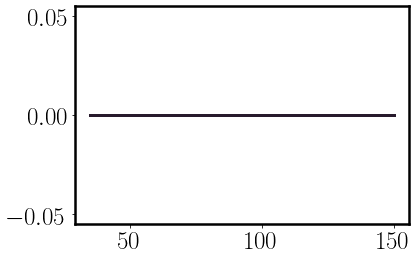

In [29]:
i = 9
xi = xi_vals[i]
y = (1-xi-eta)*dR_Iso + eta*dR_Saus + xi*dR1
plt.fill_between(Evals,y,y2=dR0,color=col[i,:],zorder=3)
plt.plot(Evals,y,'-',color=col[i,:],linewidth=3,zorder=3)

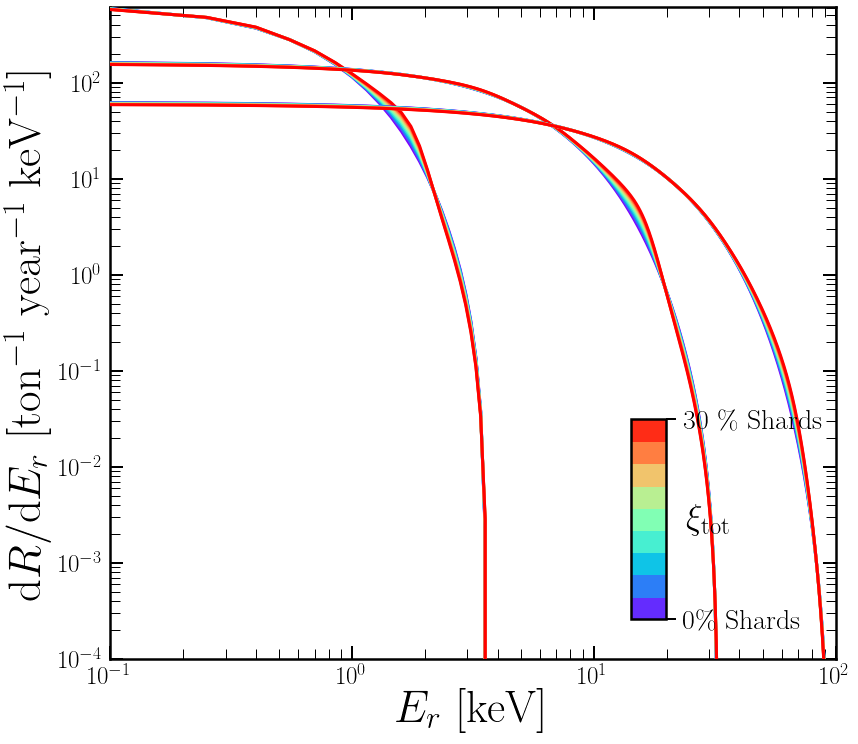

In [98]:
# Figure setup
xlab = r"$E_r$ [keV]"
ylab = r'$\textrm{d}R/\textrm{d}E_r$ [ton$^{-1}$ year$^{-1}$ keV$^{-1}$]'
fig,ax = MySquarePlot(xlab,ylab)


A = 131
sigma_p = 1.0e-45

for m_chi in [6.0,20.0,50.0]:
    dR_Iso,dR_Iso_gf,dR_Saus,dR_Saus_gf,dR_Sh,dR_Sh_gf = InterpdR(Evals,A,m_chi,sigma_p)
    dR0 = (1-eta)*dR_Iso + eta*dR_Saus
    dR1 = sum(dR_Sh,0)
    for i in range(0,n_xi):
        xi = xi_vals[i]
        y = (1-xi-eta)*dR_Iso + eta*dR_Saus + xi*dR1
        ax.fill_between(Evals,y,y2=dR0,color=col[i,:],zorder=3)
        ax.plot(Evals,y,'-',color=col[i,:],linewidth=3,zorder=3)
    
    
# Plot fiddling
# Style
ax.set_xlim(left=0.1,right=100.0)
ax.set_ylim(bottom=1.0e-4)
plt.yscale('log')
plt.xscale('log')



# # Custom colorbar
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbar_max = r'30 \% Shards'
cbar_min = r'0\% Shards'
cbaxes = inset_axes(ax, width="5%", height="50%", bbox_to_anchor=[-15, -40, 700, 400]) 
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=(0,1),boundaries=linspace(0,1,n_xi))
f = plt.gcf().get_children()
cbar = f[2]
cbar.set_yticklabels([cbar_min, cbar_max])  # vertically oriented colorbar
cbar.tick_params(labelsize=28) 
cbar.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7)
cbar.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False)
plt.gcf().text(0.74,0.27,r'$\xi_{\rm tot}$',fontsize=35,color='k')


# Save figure
plt.show()
pltname = 'Shards_dRdE_Alt'
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

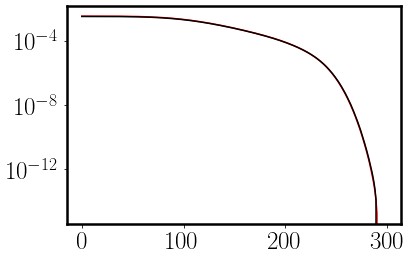

In [53]:
plt.plot(gmin_Saus,'r-')
plt.plot(gmin_Saus_gf,'k-')
plt.yscale('log')

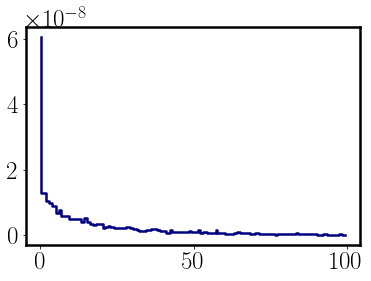

In [120]:
dat = loadtxt('../data/LZ/LZ_materials.csv',delimiter=',')
plt.step(dat[:,0],10.0**dat[:,1],'-',lw=2.5,color='navy')
plt.show()

In [119]:
dat[:,0]

array([ 0.27932961,  1.11731844,  1.95530726,  2.93296089,  4.05027933,
        5.16759777,  6.1452514 ,  6.98324022,  8.24022346,  9.4972067 ,
       10.05586592, 11.31284916, 12.01117318, 13.26815642, 14.24581006,
       15.22346369, 16.20111732, 17.31843575, 18.29608939, 19.41340782,
       20.53072626, 21.08938547, 22.06703911, 22.90502793, 24.02234637,
       25.27932961, 26.81564246, 28.0726257 , 29.32960894, 30.30726257,
       31.00558659, 31.70391061, 32.12290503, 33.24022346, 34.63687151,
       35.05586592, 36.17318436, 37.01117318, 38.12849162, 38.96648045,
       40.22346369, 41.06145251, 42.17877095, 43.01675978, 43.99441341,
       45.11173184, 46.22905028, 47.20670391, 48.32402235, 49.16201117,
       50.1396648 , 51.39664804, 52.09497207, 52.93296089, 54.32960894,
       55.02793296, 56.1452514 , 57.12290503, 57.54189944, 58.10055866,
       59.07821229, 60.33519553, 61.17318436, 62.15083799, 62.98882682,
       64.24581006, 65.22346369, 66.34078212, 67.03910615, 68.43